In [558]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu, shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

from tqdm.auto import tqdm

### Задание 1

#### Описание файлов
**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)  
**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента  
**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента

In [424]:
groups = pd.read_csv('groups.csv', delimiter=';')
checks = pd.read_csv('checks.csv', delimiter=';')
active_studs = pd.read_csv('active_studs.csv', delimiter=';')
group_add = pd.read_csv('group_add.csv')

#### PRELIMINARY EDA
Проведем предварительный анализ всех таблиц, которые даны по условию


In [425]:
# Посмотрим на датафрейм groups
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [426]:
# Посмотрим на длину таблицы, количество пользователей в контрольной (А) и тестовой (В) группе
len(groups)

74484

In [427]:
groups.grp.value_counts(normalize=True) * 100

B    80.303152
A    19.696848
Name: grp, dtype: float64

Разбивка пользователей перекошена в сторону тестовой группы - 80% против 20%. Немного необычное решение для проведения А/В теста, обычно ситуация обратная

In [428]:
# Посмотрим на датафрейм active_studs
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [429]:
len(active_studs)

8341

Таблица состоит из одного столбца, в котором указаны id тех, кто зашел на платформу. Всего таких пользователей было 8341

In [430]:
# На всякий случай уточним, являются ли id уникальными в этой таблице. Возможно учитывался каждый заход пользователя
len(active_studs.student_id.value_counts())

8341

Групировка по id дала таблицу такой же блины, как и исходный - значения уникальные

In [431]:
# Посмотрим на датафрейм active_studs
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [432]:
# Переведем float значения в int, чтобы убрать ненужные нули после запятой
checks['rev'] = checks.rev.astype(int)

In [433]:
len(checks)

541

Всего за 2 дня проведения эксперимента покупку совершил 541 пользователь

In [434]:
# Посмотрим на базовые статистики покупок за эти дни
checks.rev.describe()

count     541.000000
mean     1059.752311
std       762.712351
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [435]:
# Проверим были ли те пользователи, кто совершил несколько покупок за эти дни
len(checks.groupby('student_id', as_index=False)
        .count()
        .query('rev > 1')
   )

0

Все покупали только 1 раз, тех, кто делал покупку дважды и более раз - нет

In [436]:
# Чуть более подробно посмотрим на тип покупок по их размеру
checks_cnt = checks.rev.value_counts().reset_index()

checks_cnt.head()

,index,rev
0,1900,133
1,290,94
2,690,78
3,199,46
4,990,41


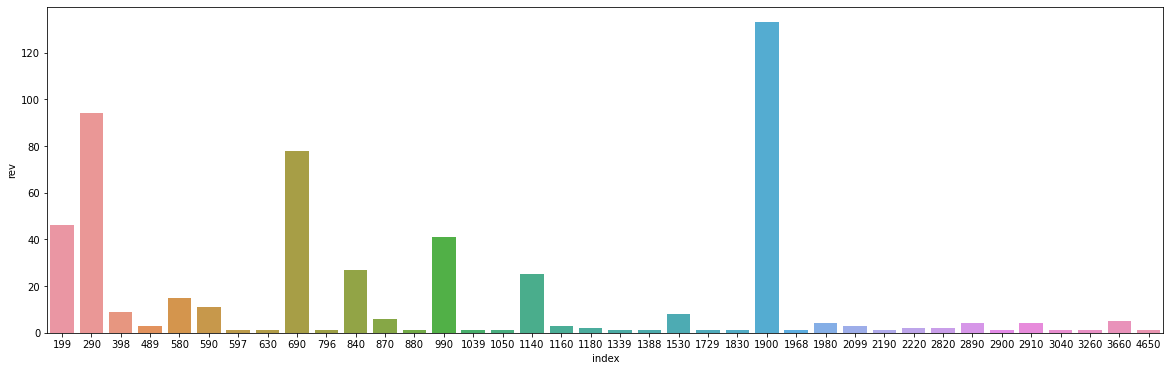

In [437]:
plt.figure(figsize=(20,6))

ax = sns.barplot(data=checks_cnt, x='index', y='rev')

#### Подготовка данных для оценки А/В теста

Вначале необходимо распредилить по группам тех пользователей, кто заходил на сайт

In [438]:
# Добавим к списку с теми, кто зашел на сайт разбивку на группы
active_groups = active_studs.merge(groups, how='inner', left_on='student_id', right_on='id')[['id', 'grp']]

active_groups.head()

,id,grp
0,581585,A
1,3276743,B
2,4238589,A
3,4475369,B
4,5481015,B


In [439]:
# Посмотрим на размер датафрейма и распределение по группам тех, кто заходил на сайт

print(f'Количество записей в датафрейме = {len(active_groups)}')
print('\nРаспределение пользователей по тестовой и контрольной группе:')
active_groups.grp.value_counts(normalize=True)

Количество записей в датафрейме = 8328

Распределение пользователей по тестовой и контрольной группе:


B    0.815682
A    0.184318
Name: grp, dtype: float64

Распределение по группам среди тех, кто заходил на сайт примерно равно изначальному распределению по группам: 82% против 18%.  
При этом нас интересует поседение этих пользователей с точки зрения оплаты, поэтому необходимо добавить данные об оплатах к получившейся таблице active_groups

In [440]:
# Соединим два датафрейма и оставим только нужные нам столбцы в удобном порядке
df = active_groups.merge(checks, left_on='id', right_on='student_id', how='left')[['grp', 'id', 'rev']]

df.head()

,grp,id,rev
0,A,581585,NaN
1,B,3276743,NaN
2,A,4238589,NaN
3,B,4475369,NaN
4,B,5481015,NaN


In [441]:
# Посмотрим на описание датафрейма и базовые статистики
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8328 entries, 0 to 8327
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   grp     8328 non-null   object 
 1   id      8328 non-null   int64  
 2   rev     391 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.2+ KB


Мы видим, что только 391 пользователь из тех, кто зашел на сайт и совершили покупку. Исходя из задания следует, что менялась именно механика оплаты, поэтому в данном исследовании я предполагаю, что основная метрика, которая нас интересует - конверсия захода на сайт в покупку, а не средний чек, так как если меняется именно механика оплаты, то основное влияние должно быть на конверсию, а не на средний чек.  

Средний чек мы отследим как побочную метрику, но только на тех, кто в итоге совершил покупку, смотреть на средний чек на всех зашедших на сайт не имеет смысла, так как конверсия является тем, что драйвит средний чек, если мы его считаем на всех пользователях.

In [442]:
# Добавим столбец с меткой о покупке
df['is_purchase'] = df.rev.apply(lambda x: True if x >=0 else False)
df['is_purchase'] = df.is_purchase.apply(lambda x: 0 if x == False else 1)

In [443]:
df.tail()

,grp,id,rev,is_purchase
8323,B,1794344,NaN,0
8324,B,296883,NaN,0
8325,B,3598448,NaN,0
8326,B,3610547,290.0,1
8327,B,205705,NaN,0


#### Проведение A/B тестов

In [444]:
# Посмотрим на конверсию в контрольной и целевой группах
df.groupby('grp').is_purchase.mean()

grp
A    0.050814
B    0.046077
Name: is_purchase, dtype: float64

In [445]:
control_conv = df.query('grp == "A"')[['is_purchase']]
treatment_conv = df.query('grp == "B"')[['is_purchase']]

Так как значение покупки бинарно: 1-покупка, 0-отсутствие покупки. При проведении теста применим бутстрап

In [446]:
result = []
boot_it = 1000
base_diff = abs(np.mean(control_conv) - np.mean(treatment_conv))

for _ in tqdm(range(boot_it)):
        samples_1 = df['is_purchase'].sample(len(control_conv), replace=True).mean()
        samples_2 = df['is_purchase'].sample(len(treatment_conv), replace=True).mean()
        result.append(np.abs(samples_1 - samples_2) >= base_diff)
        
print(f'P-value: {np.mean(result)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.438


Вероятность получить такую и большую разницу составляет 0.404.
Мы не можем отбросить нулевую гипотезу о том, что между конверсиями групп существует статистически значимая разница.

Теперь проверим статистическую разницу в побочной метрике - среднем чеке

In [447]:
# Сделаем отдельный датафрейм, где мы будем учитывать только пользователей с совершенными покупками,
# для подсчета среднего по двум тестовым группам

df_purchase = df.query('is_purchase == True')
df_purchase.head()

,grp,id,rev,is_purchase
61,A,1184303,1530.0,1
66,B,3354191,1900.0,1
76,B,3278734,1900.0,1
98,A,720651,1980.0,1
191,B,1232221,1900.0,1


In [448]:
df_purchase.groupby('grp').rev.agg(['mean', 'count'])

,mean,count
grp,,
A,933.589744,78
B,1255.827476,313


Разобьем исходный датафрейм на два, согласно группам, по покупкам

In [449]:
control_rev = df_purchase.query('grp == "A"')[['rev']]
treatment_rev = df_purchase.query('grp == "B"')[['rev']]

Проверим датафреймы на нормальность распределения

In [450]:
print('Результаты теста Шапиро–Уилка:');
print(f'Control group p-value: {shapiro(control_rev)[1]}');
print(f'Treatment group p-value: {shapiro(treatment_rev)[1]}')

Результаты теста Шапиро–Уилка:
Control group p-value: 1.4986822893803264e-10
Treatment group p-value: 1.756778758085431e-16


array([[<AxesSubplot:title={'center':'rev'}>]], dtype=object)

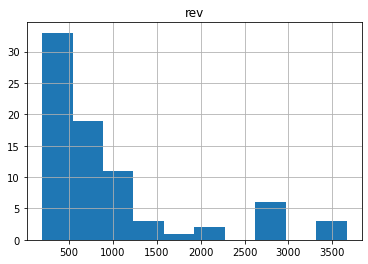

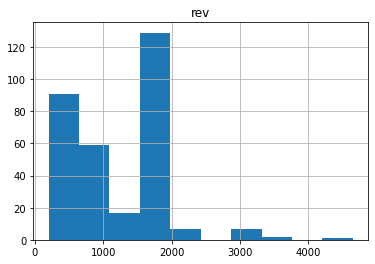

In [451]:
control_rev.hist()
treatment_rev.hist()

Распределение размера покупок не является нормальным для обеих групп, поэтому при проведении А/В теста будем использовать метод бутстрапа

In [452]:
result = []
boot_it = 1000
base_diff = abs(np.mean(control_rev) - np.mean(treatment_rev))

for _ in tqdm(range(boot_it)):
        samples_1 = df_purchase['rev'].sample(len(control_rev), replace=True).mean()
        samples_2 = df_purchase['rev'].sample(len(treatment_rev), replace=True).mean()
        result.append(np.abs(samples_1 - samples_2) >= base_diff)
        
print(f'P-value: {np.mean(result)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.002


Вероятность получить такую и большую разницу в среднем чеке составляет 0.001. Мы можем отклонить нулевую гипотезу о том, что средние не различаются. Разница в размере среднего чека является статистически значимой.

При этом, так как основная метрика, которая нас интересует, была конверсией, то в таком случае, **мы должны отказаться от запуска новой механики на всех пользователей**, так как основная задача (повышение конверсии) дорстигнута не была.

### Задание 2

In [ ]:
Задание выполняется при помощи SQL запроса в базу данных, в которой со

In [453]:
import pandahouse as ph

In [454]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

#### Задание 2.1

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".  
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Задание:** Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [456]:
q = '''
    SELECT COUNT(*) AS hard_workers
    FROM (
            SELECT st_id
                 , SUM(correct) AS amount_solved
              FROM default.peas
             GROUP BY st_id
            HAVING amount_solved >= 20
             ORDER BY amount_solved DESC
    ) AS t
    '''

ph.read_clickhouse(query=q, connection=connection_default)

,hard_workers
0,136


#### Задание 2.2

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU  
- ARPAU  
- CR в покупку  
- СR активного пользователя в покупку  
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  
- ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
**Активным по математике** считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [459]:
q = '''
    SELECT test_grp
         , SUM(payments) /
           COUNT(st_id) AS ARPU
         , SUM(CASE WHEN correct_cnt >= 10 THEN payments Else 0 END) /
           COUNT(CASE WHEN correct_cnt >= 10 THEN st_id Else NULL END) AS ARPAU
         , COUNT(CASE WHEN payments > 0 THEN st_id Else NULL END) /
           COUNT(st_id) * 100 AS CR_to_purchase
         , COUNT(CASE WHEN payments > 0 AND correct_cnt >= 10 THEN st_id Else NULL END) /
           COUNT(CASE WHEN correct_cnt >= 10 THEN st_id Else NULL END) * 100 AS CR_to_purchase_active
         , SUM(CASE WHEN math_active = 1 THEN buy_math ELSE 0 END) /
           SUM(math_active) * 100 AS CR_in_math_active
      FROM (
                SELECT l.st_id AS st_id
                     , test_grp
                     , correct_cnt
                     , payments
                     , CASE WHEN LENGTH(r3.math) > 0 THEN 1 ELSE 0 END AS buy_math
                     , CASE WHEN LENGTH(r4.math_active) > 0 THEN 1 ELSE 0 END AS math_active
                  FROM studs AS l
             LEFT JOIN (
                         SELECT st_id, SUM(correct) AS correct_cnt
                         FROM peas
                         GROUP BY st_id
                       ) AS r
                    ON l.st_id = r.st_id
             LEFT JOIN (
                         SELECT st_id, SUM(money) AS payments
                         FROM final_project_check
                         GROUP BY st_id
                       ) AS r2
                    ON l.st_id = r2.st_id
             LEFT JOIN (
                         SELECT st_id AS math
                           FROM final_project_check
                          WHERE subject = 'Math'
                       ) AS r3
                    ON l.st_id = r3.math
             LEFT JOIN (
                         SELECT st_id AS math_active, SUM(correct) AS cnt
                           FROM peas
                          WHERE subject = 'Math'
                          GROUP BY st_id
                         HAVING cnt >= 2
                       ) AS r4
                    ON l.st_id = r4.math_active
           ) AS t
     GROUP BY test_grp
    '''

df_ch = ph.read_clickhouse(query=q, connection=connection_default)

df_ch

,test_grp,ARPU,ARPAU,CR_to_purchase,CR_to_purchase_active,CR_in_math_active
0,control,4540.983607,10000.000000,4.918033,10.606061,6.122449
1,pilot,11508.474576,28267.326733,10.847458,24.752475,9.523810


### Задача 3

1) Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики
2) Реализуйте функцию, которая будет строить графики по получаемым метрикам

In [637]:
# Функция для подсчета метрик
def metrics_counter(main_df, additional_df, activity_df, checks_df):
    # Объединим два датафрейма
    full_df = main_df.append(additional_df)
    # Добавим данные о покупках для активных пользователей
    full_df = activity_df.merge(full_df, how='inner', left_on='student_id', right_on='id')[['id', 'grp']]
    full_df = full_df.merge(checks_df, left_on='id', right_on='student_id', how='left')[['grp', 'id', 'rev']]
    full_df['is_purchase'] = full_df.rev.apply(lambda x: True if x >=0 else False)
    full_df['is_purchase'] = full_df.is_purchase.apply(lambda x: 0 if x == False else 1)
    # Посчитаем необходимые метрики (в данном случае нас интересует средний чек и конверсия в покупку)
    metrics = full_df.groupby('grp') \
                    .agg({'is_purchase': 'mean', 'rev': 'mean'}) \
                    .reset_index() \
                    .rename(columns={'is_purchase': 'CR', 'rev': 'avg_check'})
    # Выведем данные метрик
    return metrics

In [638]:
# Функция для создания графиков
def metrics_graph_builder(main_df, additional_df, activity_df, checks_df):
    # Объединим два датафрейма
    full_df = main_df.append(additional_df)
    # Добавим данные о покупках для активных пользователей
    full_df = activity_df.merge(full_df, how='inner', left_on='student_id', right_on='id')[['id', 'grp']]
    full_df = full_df.merge(checks_df, left_on='id', right_on='student_id', how='left')[['grp', 'id', 'rev']]
    full_df['is_purchase'] = full_df.rev.apply(lambda x: True if x >=0 else False)
    full_df['is_purchase'] = full_df.is_purchase.apply(lambda x: 0 if x == False else 1)
    # Подготовим данные для построения графиков
    df_cr = full_df[['grp','is_purchase']].groupby('grp').agg({'is_purchase': ['sum', 'count']})
    df_cr.columns = df_cr.columns.droplevel(level=0)
    df_cr = df_cr.reset_index()
    
    # Выведем графики
    plt.title("Average check by group")
    sns.boxplot(data=full_df, x="grp", y="rev")
    
    plt.title("CR into purchase by group")
    df_cr.plot.bar(x='grp', stacked=True, title='CR in purchase')

    plt.tight_layout()

In [639]:
# Проверим работу функций
metrics_counter(groups, group_add, active_studs, checks)

,grp,CR,avg_check
0,A,0.050715,933.589744
1,B,0.046156,1257.878981


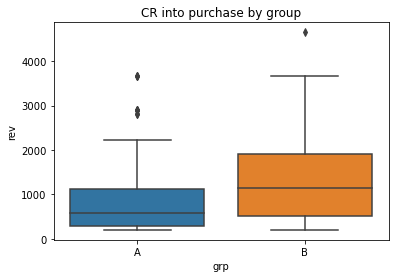

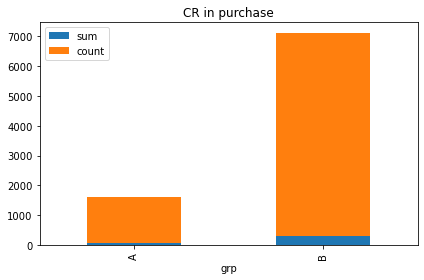

In [640]:
metrics_graph_builder(groups, group_add, active_studs, checks)